# Case Study 1

#### Predicting Central Neuropathic Pain (CNP) in people with Spinal Cord Injury (SCI) from Electroencephalogram (EEG) data.

* CNP is pain in response to non-painful stimuli, episodic (electric shock), “pins and needles”, numbness
* There is currently no treatment, only prevention
* Preventative medications have strong side-effects
* Predicting whether a patient is likely to develop pain is useful for selective treatment

#### Task
Your task is to devise a feature engineering strategy which, in combination with a classifier of your choice, optizimes prediction accuracy.

#### Data
The data is preprocessed brain EEG data from SCI patients recorded while resting with eyes closed (EC) and eyes opened (EO).
* 48 electrodes recording electrical activity of the brain at 250 Hz 
* 2 classes: subject will / will not develop neuropathic pain within 6 months
* 18 subjects: 10 developed pain and 8 didn’t develop pain
* the data has already undergone some preprocessing
  * Signal denoising and normalization
  * Temporal segmentation
  * Frequency band power estimation
  * Normalization with respect to total band power
  * Features include normalized alpha, beta, theta band power while eyes closed, eyes opened, and taking the ratio of eo/ec.
* the data is provided in a single table ('data.csv') consisting of 
  * 180 rows (18 subjects x 10 repetitions), each containing
  * 432 columns (9 features x 48 electrodes)
  * rows are in subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
  * columns are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
  * feature identifiers for all columns are stored in 'feature_names.csv'
  * 'labels.csv' defines the corresponding class (0 or 1) to each row in data.csv

#### Objective Measure
Leave one subject out cross-validation accuracy, sensitivity and specificity.

#### Report
Report on your feature engineering pipeline, the classifier used to evaluate performance, and the performance as mean and standard deviation of accuracy, sensitivity and specificity across folds. Give evidence for why your strategy is better than others.





In [376]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt


## Dataset



In [377]:
X = np.loadtxt('data.csv', delimiter=',') 
y = np.loadtxt('labels.csv', delimiter=',')
with open('feature_names.csv') as f:
    csvreader = csv.reader(f, delimiter=',')
    feature_names = [row for row in csvreader][0]

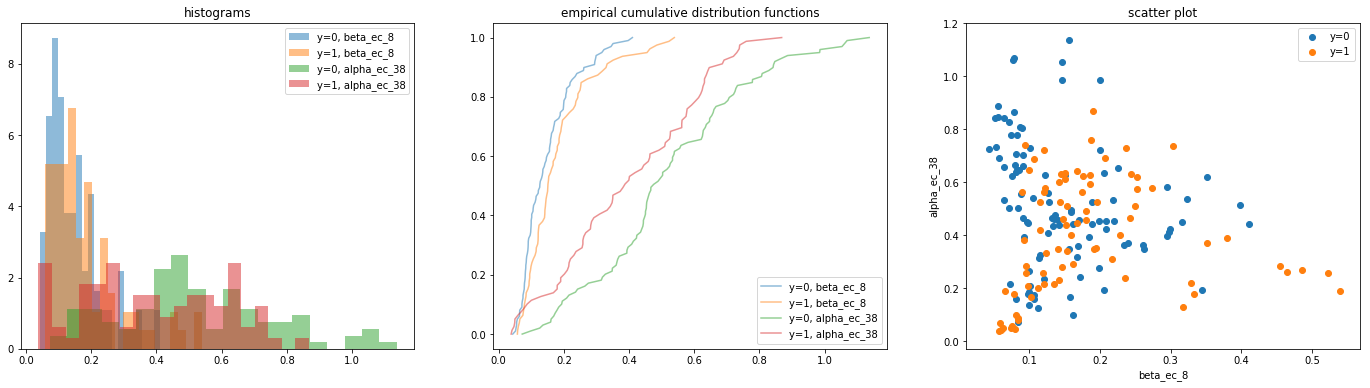

In [378]:
# plotting data in 2D with axes sampled 
# a) at random 
# b) from same electrode
# c) from same feature type
num_features = 9
num_electrodes = 48

# a) indices drawn at random
i0, i1 = np.random.randint(0, X.shape[1], size=2)

# b) same electrode, different feature (uncomment lines below)
#f0, f1 = np.random.randint(0, num_features, size=2)
#e = np.random.randint(0, num_electrodes)
#i0, i1 = f0*num_electrodes + e, f1*num_electrodes + e

# b) same feature, different electrode (uncomment lines below)
#f = np.random.randint(0, num_features)
#e0, e1 = np.random.randint(0, num_electrodes, size=2)
#i0, i1 = f*num_electrodes + e0, f*num_electrodes + e1

fig, axes = plt.subplots(1, 3, figsize=(24, 6))
colors = ['blue', 'red']

# select features i0, i1 and separate by class
X00, X01 = X[y==0][:,i0], X[y==1][:,i0]
X10, X11 = X[y==0][:,i1], X[y==1][:,i1]
# plot cumulative distribution of feature i0 separate for each class
axes[0].hist(X00, bins=20, label='y=0, '+ feature_names[i0], density=True, alpha=0.5)
axes[0].hist(X01, bins=20, label='y=1, '+ feature_names[i0], density=True, alpha=0.5)
axes[0].hist(X10, bins=20, label='y=0, '+ feature_names[i1], density=True, alpha=0.5)
axes[0].hist(X11, bins=20, label='y=1, '+ feature_names[i1], density=True, alpha=0.5)
axes[0].set_title('histograms')
axes[0].legend()
axes[1].plot(np.sort(X00), np.linspace(0,1,X00.shape[0]), label='y=0, '+ feature_names[i0], alpha=0.5)
axes[1].plot(np.sort(X01), np.linspace(0,1,X01.shape[0]), label='y=1, '+ feature_names[i0], alpha=0.5)
axes[1].plot(np.sort(X10), np.linspace(0,1,X10.shape[0]), label='y=0, '+ feature_names[i1], alpha=0.5)
axes[1].plot(np.sort(X11), np.linspace(0,1,X11.shape[0]), label='y=1, '+ feature_names[i1], alpha=0.5)
axes[1].set_title('empirical cumulative distribution functions')
axes[1].legend()
axes[2].scatter(X00, X10, label='y=0')
axes[2].scatter(X01, X11, label='y=1')
axes[2].set_xlabel(feature_names[i0])
axes[2].set_ylabel(feature_names[i1])
axes[2].set_title('scatter plot')
axes[2].legend()

In [382]:
dataframe = pd.DataFrame(X, columns=feature_names)
dataframe.head()

,alpha_ec_0,alpha_ec_1,alpha_ec_2,alpha_ec_3,alpha_ec_4,alpha_ec_5,alpha_ec_6,alpha_ec_7,alpha_ec_8,alpha_ec_9,...,ratio_theta_38,ratio_theta_39,ratio_theta_40,ratio_theta_41,ratio_theta_42,ratio_theta_43,ratio_theta_44,ratio_theta_45,ratio_theta_46,ratio_theta_47
0,0.11184,0.12387,0.12858,0.11324,0.10571,0.10690,0.10756,0.11064,0.10875,0.15893,...,0.57161,0.73870,0.58709,0.55198,0.54811,0.57869,0.59345,0.60436,0.56294,1.01440
1,0.29834,0.26881,0.26239,0.38009,0.34358,0.28500,0.24791,0.25033,0.26047,0.26016,...,0.35142,0.32788,0.43164,0.49603,0.40680,0.31283,0.66352,0.58386,0.46658,0.74867
2,0.36912,0.39587,0.38999,0.25772,0.40554,0.44199,0.44004,0.39947,0.31546,0.28348,...,0.61924,0.86506,1.09310,0.31759,0.36353,0.50553,0.33478,0.49383,0.62363,0.61417
3,0.76120,0.77726,0.77042,0.60161,0.70183,0.72725,0.76245,0.78904,0.72984,0.52236,...,0.23456,0.25090,0.43196,0.71301,0.53340,0.28528,0.68135,0.66315,0.25250,0.85448
4,0.16770,0.15146,0.14714,0.15728,0.14965,0.14154,0.13228,0.12760,0.14351,0.17252,...,1.82160,1.73190,1.24420,2.76220,3.00930,2.43520,2.53070,2.58470,2.00770,2.29460


## Normalisation

In [80]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [384]:
def scale(X):
    scaler = StandardScaler()
    data = X
    scaler.fit(data)
    newdata = scaler.transform(data)
    return newdata

In [385]:
auc_results(scale(X))
cv_results(scale(X))

Logistic regression
AUC:0.9249999999999999
Confusion matrix:
[[28  2]
 [ 2 22]]
Accuracy: 0.9259259259259259
Sensitivity:0.9166666666666666
Specificity:0.9333333333333333


Decision Tree:
AUC:0.7291666666666667
Confusion matrix:
[[25  5]
 [ 9 15]]
Accuracy: 0.7407407407407407
Sensitivity:0.625
Specificity:0.8333333333333334

 
Random forrest:
AUC:0.7125
Confusion matrix:
[[24  6]
 [ 9 15]]
Accuracy: 0.7222222222222222
Sensitivity:0.625
Specificity:0.8

 
LGR
Avg loss: 0.07222222222222224

DT
Avg loss: 0.2777777777777778

RFC
Avg loss: 0.15555555555555556



In [386]:
scaler = MinMaxScaler()
data = X
scaler.fit(data)
newdata = scaler.transform(data)
pd.DataFrame(newdata, columns=feature_names).head()

,alpha_ec_0,alpha_ec_1,alpha_ec_2,alpha_ec_3,alpha_ec_4,alpha_ec_5,alpha_ec_6,alpha_ec_7,alpha_ec_8,alpha_ec_9,...,ratio_theta_38,ratio_theta_39,ratio_theta_40,ratio_theta_41,ratio_theta_42,ratio_theta_43,ratio_theta_44,ratio_theta_45,ratio_theta_46,ratio_theta_47
0,0.070350,0.079269,0.072532,0.071386,0.062224,0.063005,0.059758,0.064540,0.055414,0.100919,...,0.094498,0.090847,0.061854,0.091076,0.057430,0.082662,0.113275,0.090422,0.072849,0.157680
1,0.267545,0.240236,0.223526,0.351345,0.337907,0.275265,0.230180,0.241817,0.254206,0.210730,...,0.045912,0.027384,0.038127,0.078185,0.035671,0.033712,0.131734,0.085575,0.054201,0.106081
2,0.342384,0.381345,0.367512,0.222964,0.409716,0.462366,0.463477,0.431087,0.326256,0.236026,...,0.105008,0.110367,0.139086,0.037071,0.029008,0.069192,0.045129,0.064286,0.084594,0.079964
3,0.756948,0.804906,0.796795,0.583748,0.753106,0.802340,0.854968,0.925480,0.869198,0.495153,...,0.020126,0.015493,0.038176,0.128179,0.055165,0.028640,0.136432,0.104324,0.012772,0.126627
4,0.129414,0.109910,0.093476,0.117589,0.113149,0.104289,0.089774,0.086064,0.100959,0.115661,...,0.370315,0.244275,0.162149,0.600332,0.436416,0.424481,0.623639,0.558706,0.352440,0.406265


In [387]:
auc_results(newdata)
cv_results(newdata)

Logistic regression
AUC:0.8208333333333334
Confusion matrix:
[[28  2]
 [ 7 17]]
Accuracy: 0.8333333333333334
Sensitivity:0.7083333333333334
Specificity:0.9333333333333333


Decision Tree:
AUC:0.7375
Confusion matrix:
[[23  7]
 [ 7 17]]
Accuracy: 0.7407407407407407
Sensitivity:0.7083333333333334
Specificity:0.7666666666666667

 
Random forrest:
AUC:0.7291666666666667
Confusion matrix:
[[25  5]
 [ 9 15]]
Accuracy: 0.7407407407407407
Sensitivity:0.625
Specificity:0.8333333333333334

 
LGR
Avg loss: 0.1

DT
Avg loss: 0.2833333333333333

RFC
Avg loss: 0.16111111111111112



In [388]:
# UNIT LENGTH
from sklearn.preprocessing import Normalizer

scaler = Normalizer()
data = X
scaler.fit(data)
newdata = scaler.transform(data)
pd.DataFrame(newdata, columns=feature_names).head()

,alpha_ec_0,alpha_ec_1,alpha_ec_2,alpha_ec_3,alpha_ec_4,alpha_ec_5,alpha_ec_6,alpha_ec_7,alpha_ec_8,alpha_ec_9,...,ratio_theta_38,ratio_theta_39,ratio_theta_40,ratio_theta_41,ratio_theta_42,ratio_theta_43,ratio_theta_44,ratio_theta_45,ratio_theta_46,ratio_theta_47
0,0.007201,0.007975,0.008278,0.007291,0.006806,0.006883,0.006925,0.007123,0.007002,0.010232,...,0.036802,0.047560,0.037799,0.035538,0.035289,0.037258,0.038208,0.038911,0.036244,0.065310
1,0.008294,0.007473,0.007294,0.010566,0.009551,0.007923,0.006892,0.006959,0.007241,0.007232,...,0.009769,0.009115,0.011999,0.013789,0.011309,0.008696,0.018445,0.016231,0.012970,0.020812
2,0.028684,0.030763,0.030306,0.020027,0.031515,0.034347,0.034196,0.031043,0.024514,0.022029,...,0.048121,0.067224,0.084945,0.024680,0.028250,0.039285,0.026016,0.038376,0.048462,0.047727
3,0.022212,0.022680,0.022481,0.017555,0.020479,0.021221,0.022248,0.023024,0.021297,0.015242,...,0.006844,0.007321,0.012605,0.020805,0.015565,0.008324,0.019882,0.019351,0.007368,0.024934
4,0.010058,0.009084,0.008825,0.009433,0.008976,0.008489,0.007934,0.007653,0.008607,0.010347,...,0.109255,0.103875,0.074624,0.165670,0.180491,0.146058,0.151786,0.155024,0.120417,0.137625


In [389]:
auc_results(newdata)
cv_results(newdata)

Logistic regression
AUC:0.6416666666666667
Confusion matrix:
[[26  4]
 [14 10]]
Accuracy: 0.6666666666666666
Sensitivity:0.4166666666666667
Specificity:0.8666666666666667


Decision Tree:
AUC:0.6625
Confusion matrix:
[[21  9]
 [ 9 15]]
Accuracy: 0.6666666666666666
Sensitivity:0.625
Specificity:0.7

 
Random forrest:
AUC:0.7166666666666666
Confusion matrix:
[[23  7]
 [ 8 16]]
Accuracy: 0.7222222222222222
Sensitivity:0.6666666666666666
Specificity:0.7666666666666667

 
LGR
Avg loss: 0.3444444444444444

DT
Avg loss: 0.3277777777777778

RFC
Avg loss: 0.2277777777777778



# Feature Selection

In [390]:
from sklearn.feature_selection import VarianceThreshold

### Variance threshold 
##### 432 features --> 107 features

In [464]:
# variance threshold
def variance_threshold(X):
    sel = VarianceThreshold(threshold=(.7 * (1 - .7)))
    newdata = sel.fit_transform(X)
    print("Num Features: ", newdata.shape[1])
    return auc_results(newdata), cv_results(newdata)

In [466]:
variance_threshold(X)

Num Features:  99
Logistic regression
AUC:0.8458333333333332
Confusion matrix:
[[27  3]
 [ 5 19]]
Accuracy: 0.8518518518518519
Sensitivity:0.7916666666666666
Specificity:0.9


Decision Tree:
AUC:0.5999999999999999
Confusion matrix:
[[21  9]
 [12 12]]
Accuracy: 0.6111111111111112
Sensitivity:0.5
Specificity:0.7

 
Random forrest:
AUC:0.7375
Confusion matrix:
[[23  7]
 [ 7 17]]
Accuracy: 0.7407407407407407
Sensitivity:0.7083333333333334
Specificity:0.7666666666666667

 
LGR
Avg loss: 0.19999999999999998

DT
Avg loss: 0.2833333333333334

RFC
Avg loss: 0.2611111111111111



(None, None)

### SelectKBest

#### increases every one with a different value of k

In [395]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [401]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

def select_k_best_findk(X):


    max_LR =0
    k_LR = 0
    max_DT =  0
    k_DT = 0
    max_RF =  0
    k_RF = 0

    for i in range(100, X.shape[1]):
        newdata = SelectKBest(chi2, k=i).fit_transform(X, y)
        lr,_ = log_reg(newdata, y)
        dt,_ = decision_tree(newdata, y)
        rf,_ = random_forrest(newdata, y)

        if lr > max_LR:
            max_LR = lr
            k_LR = i
        if dt > max_DT:
            max_DT = dt
            k_DT = i
        if rf > max_RF:
            max_RF = rf
            k_RF = i


    print("LR auc={}, k={}".format(max_LR, k_LR))
    print("DT auc={}, k={}".format(max_DT, k_DT))
    print("RF auc={}, k={}".format(max_RF, k_RF))

In [402]:
select_k_best_findk(X)

LR auc=0.9041666666666667, k=102
DT auc=0.7958333333333334, k=312
RF auc=0.7666666666666666, k=321


In [403]:
# LR Only

def select_k_best(X):
    lr_data = SelectKBest(chi2, k=102).fit_transform(X, y)
    return lr_data

### L1 based feature selection

In [127]:
from sklearn.feature_selection import SelectFromModel

In [404]:
def l1_feature_selection(X):
    lr = LogisticRegression().fit(X,y)
    model = SelectFromModel(lr, prefit=True)
    newdata = model.transform(X)
    print(newdata.shape)
    return auc_results(newdata), cv_results(newdata)

In [406]:
l1_feature_selection(X)

(180, 161)
Logistic regression
AUC:0.9083333333333332
Confusion matrix:
[[27  3]
 [ 2 22]]
Accuracy: 0.9074074074074074
Sensitivity:0.9166666666666666
Specificity:0.9


Decision Tree:
AUC:0.6958333333333332
Confusion matrix:
[[23  7]
 [ 9 15]]
Accuracy: 0.7037037037037037
Sensitivity:0.625
Specificity:0.7666666666666667

 
Random forrest:
AUC:0.7666666666666666
Confusion matrix:
[[26  4]
 [ 8 16]]
Accuracy: 0.7777777777777778
Sensitivity:0.6666666666666666
Specificity:0.8666666666666667

 
LGR
Avg loss: 0.1

DT
Avg loss: 0.21666666666666667

RFC
Avg loss: 0.15000000000000002



(None, None)

### Tree based

In [153]:
from sklearn.ensemble import ExtraTreesClassifier

In [407]:
def treebased(X):
    clf = ExtraTreesClassifier(n_estimators=50)
    clf = clf.fit(X, y)
    model = SelectFromModel(clf, prefit=True)
    newdata = model.transform(X)
    return auc_results(newdata), cv_results(newdata)

In [408]:
treebased(X)

Logistic regression
AUC:0.8083333333333333
Confusion matrix:
[[26  4]
 [ 6 18]]
Accuracy: 0.8148148148148148
Sensitivity:0.75
Specificity:0.8666666666666667


Decision Tree:
AUC:0.7541666666666668
Confusion matrix:
[[24  6]
 [ 7 17]]
Accuracy: 0.7592592592592593
Sensitivity:0.7083333333333334
Specificity:0.8

 
Random forrest:
AUC:0.75
Confusion matrix:
[[25  5]
 [ 8 16]]
Accuracy: 0.7592592592592593
Sensitivity:0.6666666666666666
Specificity:0.8333333333333334

 
LGR
Avg loss: 0.16666666666666666

DT
Avg loss: 0.30000000000000004

RFC
Avg loss: 0.12777777777777782



(None, None)

In [474]:
treebased(scale(X))

Logistic regression
AUC:0.8666666666666667
Confusion matrix:
[[27  3]
 [ 4 20]]
Accuracy: 0.8703703703703703
Sensitivity:0.8333333333333334
Specificity:0.9


Decision Tree:
AUC:0.7666666666666666
Confusion matrix:
[[26  4]
 [ 8 16]]
Accuracy: 0.7777777777777778
Sensitivity:0.6666666666666666
Specificity:0.8666666666666667

 
Random forrest:
AUC:0.75
Confusion matrix:
[[25  5]
 [ 8 16]]
Accuracy: 0.7592592592592593
Sensitivity:0.6666666666666666
Specificity:0.8333333333333334

 
LGR
Avg loss: 0.07777777777777778

DT
Avg loss: 0.2277777777777778

RFC
Avg loss: 0.17777777777777778



(None, None)

### Recursive Feature Elimination

In [211]:
from sklearn.feature_selection import RFE

## Projection - PCA

In [500]:
from sklearn.decomposition import PCA

def find_num_of_PCs(X):

    xs = []
    ys = []

    for i in range(X.shape[0]):

        pca = PCA(n_components=i)
        principalComponents = pca.fit_transform(X)

        if sum(pca.explained_variance_ratio_) > 0.8:
            xs.append(i)
            ys.append(sum(pca.explained_variance_ratio_))

            
    fig = plt.figure(figsize = (7,5))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Percentage of variance explained', fontsize = 10)
    ax.set_ylabel('Number of Principal components', fontsize = 10)
    ax.set_title('Deciding k for PCA', fontsize = 10)
    plt.plot(ys, xs)

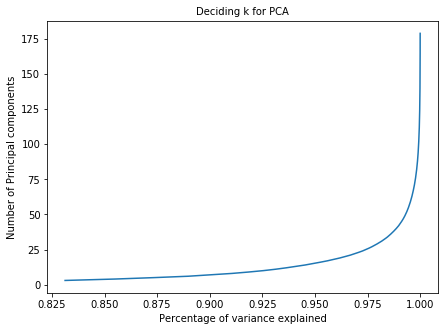

In [501]:
find_num_of_PCs(X)

#### PCA using 75 components

In [505]:

def do_PCA(X, n_components):

#     scaler = StandardScaler()
#     scaler.fit(X)
#     scaled_X = scaler.transform(data)

    pca = PCA(n_components=n_components)
    principalComponents = pca.fit_transform(X)
    principalDf = pd.DataFrame(data = principalComponents)
    print('Explained variance: ', sum(pca.explained_variance_ratio_))
    return principalDf

### PCA Results

In [479]:
principal_data = do_PCA(X, 75)
auc_results(principal_data)
cv_results(principal_data.as_matrix())

Explained variance:  0.9817450734652268
Logistic regression
AUC:0.9458333333333334
Confusion matrix:
[[28  2]
 [ 1 23]]
Accuracy: 0.9444444444444444
Sensitivity:0.9583333333333334
Specificity:0.9333333333333333


Decision Tree:
AUC:0.6625
Confusion matrix:
[[21  9]
 [ 9 15]]
Accuracy: 0.6666666666666666
Sensitivity:0.625
Specificity:0.7

 
Random forrest:
AUC:0.8208333333333334
Confusion matrix:
[[28  2]
 [ 7 17]]
Accuracy: 0.8333333333333334
Sensitivity:0.7083333333333334
Specificity:0.9333333333333333

 
LGR
Avg loss: 0.06666666666666668

DT
Avg loss: 0.31666666666666665

RFC
Avg loss: 0.2055555555555556



## AUC Scores


In [443]:
def metrics_from_confusionmatrix(conf):
    
    tn, fp, fn, tp = conf.ravel()
    accuracy =(tp+tn)/(tp+tn+fn+fp)
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    return accuracy, sensitivity, specificity


def string_metrics(conf):
    accuracy, sensitivity, specificity = metrics_from_confusionmatrix(conf)
    return "Accuracy: {}\nSensitivity:{}\nSpecificity:{}".format(accuracy, sensitivity, specificity)
    
    

In [509]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

def log_reg(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0,stratify=y)
    lgr = LogisticRegression()
    lgr.fit(X_train,y_train)
    pred = lgr.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, pred)
    auc = roc_auc_score(y_test, pred)
    conf = metrics.confusion_matrix(y_test,pred)
    
    fpr, tpr, _ = roc_curve(y_test, pred)
    auc = roc_auc_score(y_test, pred)
    plt.plot(fpr, tpr, label='auc='+str(auc))
    plt.legend(loc=4)
    return auc, conf

def decision_tree(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0,stratify=y)
    Dt = DecisionTreeClassifier()
    Dt.fit(X_train,y_train)
    pred = Dt.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, pred)
    auc = roc_auc_score(y_test, pred)
    conf = metrics.confusion_matrix(y_test,pred)
    
    fpr, tpr, _ = roc_curve(y_test, pred)
    auc = roc_auc_score(y_test, pred)
    plt.plot(fpr, tpr, label='auc='+str(auc))
    plt.legend(loc=4)
    return auc, conf

def random_forrest(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0,stratify=y)
    rfc = RandomForestClassifier(n_estimators=500)
    rfc.fit(X_train,y_train)
    pred = rfc.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, pred)
    auc = roc_auc_score(y_test, pred)
    conf = metrics.confusion_matrix(y_test,pred)
    
    fpr, tpr, _ = roc_curve(y_test, pred)
    auc = roc_auc_score(y_test, pred)
    plt.plot(fpr, tpr, label='auc='+str(auc))
    plt.legend(loc=4)
    return auc, conf


def auc_results(X):
    lr_auc, lr_conf = log_reg(X,y)
    dt_auc, dt_conf = decision_tree(X,y)
    rf_auc, rf_conf = random_forrest(X,y)

    print("Logistic regression\nAUC:{}\nConfusion matrix:\n{}\n{}\n\n".format(str(lr_auc), str(lr_conf), string_metrics(lr_conf)))
    print("Decision Tree:\nAUC:{}\nConfusion matrix:\n{}\n{}\n\n ".format(str(dt_auc), str(dt_conf), string_metrics(dt_conf)))
    print("Random forrest:\nAUC:{}\nConfusion matrix:\n{}\n{}\n\n ".format(str(rf_auc), str(rf_conf), string_metrics(rf_conf)))

    
    

## Cross Validation

#### Leave one subject out

In [445]:
# to use in leave one group out 


In [446]:
from sklearn.model_selection import LeaveOneGroupOut

def cross_validation(X,y,classifier):
    
    subject_ids = []
    for i in range(1,19):
        temp_arr = np.full((10), i).tolist()
        subject_ids.extend(temp_arr)
    subject_groups = np.array(subject_ids)

    logo = LeaveOneGroupOut()
    logo.get_n_splits(X, y, groups=subject_groups)
    i=1
    lgr = LogisticRegression()
    dt = DecisionTreeClassifier()
    rfc = RandomForestClassifier(n_estimators=500)
    loss = []

    for train_index, test_index in logo.split(X, y, subject_groups):
        #print("\tTRAIN:", train_index)
        X_train_cv, X_test_cv = X[train_index], X[test_index]
        y_train_cv, y_test_cv = y[train_index], y[test_index]
        #print("SUBJECT:", i, " TEST INDEX:", test_index)
   
        if classifier=='lgr':
            lgr.fit(X_train_cv, y_train_cv) 
            loss.append( np.mean(( y_test_cv - lgr.predict(X_test_cv) )**2  ) ) 
            pred = lgr.predict(X_test_cv)
        elif classifier =='dt':
            dt.fit(X_train_cv, y_train_cv) 
            loss.append( np.mean(( y_test_cv - dt.predict(X_test_cv) )**2  ) )
            pred = dt.predict(X_test_cv)
        elif classifier=='rfc':
            rfc.fit(X_train_cv, y_train_cv) 
            loss.append( np.mean(( y_test_cv - rfc.predict(X_test_cv) )**2  ) ) 
            pred = rfc.predict(X_test_cv)
        i+=1
        
    
    print((classifier.upper()))
    print('Avg loss:', np.mean(loss)) # print average loss at this polynomial order
    print()



In [447]:
def cv_results(data):
    cross_validation(data, y, 'lgr')
    cross_validation(data, y, 'dt')
    cross_validation(data, y, 'rfc')

In [450]:
og_data = pd.DataFrame(X, columns=feature_names)
auc_results(og_data.as_matrix())
cv_results(og_data.as_matrix())

Logistic regression
AUC:0.8875
Confusion matrix:
[[27  3]
 [ 3 21]]
Accuracy: 0.8888888888888888
Sensitivity:0.875
Specificity:0.9


Decision Tree:
AUC:0.7291666666666667
Confusion matrix:
[[25  5]
 [ 9 15]]
Accuracy: 0.7407407407407407
Sensitivity:0.625
Specificity:0.8333333333333334

 
Random forrest:
AUC:0.7125
Confusion matrix:
[[24  6]
 [ 9 15]]
Accuracy: 0.7222222222222222
Sensitivity:0.625
Specificity:0.8

 
LGR
Avg loss: 0.13888888888888892

DT
Avg loss: 0.28888888888888886

RFC
Avg loss: 0.1611111111111111



# Testing Combination Approaches

### Attempting to find best combination for Logistic Regression, Decision Tree & Random Forrest


#### Standard scaler and Variance Threshold: Variance threshold has no effect on scaled data

In [467]:
scaled_data = scale(X)
variance_threshold(scaled_data)

Num Features:  432
Logistic regression
AUC:0.9249999999999999
Confusion matrix:
[[28  2]
 [ 2 22]]
Accuracy: 0.9259259259259259
Sensitivity:0.9166666666666666
Specificity:0.9333333333333333


Decision Tree:
AUC:0.7708333333333335
Confusion matrix:
[[25  5]
 [ 7 17]]
Accuracy: 0.7777777777777778
Sensitivity:0.7083333333333334
Specificity:0.8333333333333334

 
Random forrest:
AUC:0.75
Confusion matrix:
[[25  5]
 [ 8 16]]
Accuracy: 0.7592592592592593
Sensitivity:0.6666666666666666
Specificity:0.8333333333333334

 
LGR
Avg loss: 0.07222222222222224

DT
Avg loss: 0.2944444444444445

RFC
Avg loss: 0.16111111111111112



(None, None)

### Standard scaler and Select K Best: Select K best doesn't work with scaled data as it doesn't allow negatives

### Standard scaler and L1 feature selection
#### Improvement in all models
#### Logistic regression model: Acc increase from 0.88 -> 0.94, loss decrease: 0.138->0.722
#### Decision tree model: Acc 0.685 -> 0.741, loss decrease: 0.288->0.277
#### Random forrest: Acc 0.722->0.777, loss decrease: 0.161 -> 0.151

(180, 185)
Logistic regression
AUC:0.9458333333333334
Confusion matrix:
[[28  2]
 [ 1 23]]
Accuracy: 0.9444444444444444
Sensitivity:0.9583333333333334
Specificity:0.9333333333333333


Decision Tree:
AUC:0.7458333333333333
Confusion matrix:
[[26  4]
 [ 9 15]]
Accuracy: 0.7592592592592593
Sensitivity:0.625
Specificity:0.8666666666666667

 
Random forrest:
AUC:0.7666666666666666
Confusion matrix:
[[26  4]
 [ 8 16]]
Accuracy: 0.7777777777777778
Sensitivity:0.6666666666666666
Specificity:0.8666666666666667

 
LGR
Avg loss: 0.01666666666666667

DT
Avg loss: 0.2444444444444444

RFC
Avg loss: 0.1444444444444445



(None, None)

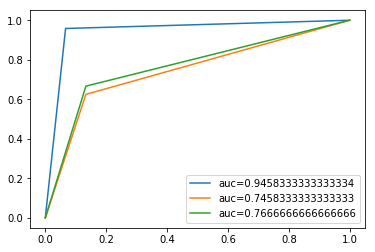

In [510]:
l1_feature_selection(scaled_data)

### Standard scaler and PCA

Logistic regression
AUC:0.8666666666666667
Confusion matrix:
[[27  3]
 [ 4 20]]
Accuracy: 0.8703703703703703
Sensitivity:0.8333333333333334
Specificity:0.9


Decision Tree:
AUC:0.6083333333333334
Confusion matrix:
[[24  6]
 [14 10]]
Accuracy: 0.6296296296296297
Sensitivity:0.4166666666666667
Specificity:0.8

 
Random forrest:
AUC:0.675
Confusion matrix:
[[28  2]
 [14 10]]
Accuracy: 0.7037037037037037
Sensitivity:0.4166666666666667
Specificity:0.9333333333333333

 
LGR
Avg loss: 0.16666666666666669

DT
Avg loss: 0.36666666666666664

RFC
Avg loss: 0.31666666666666665



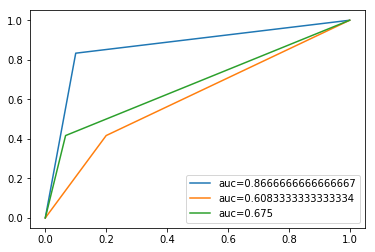

In [511]:
auc_results(principal_data)
cv_results(principal_data.as_matrix())

## Standard Scaler, L1 feature selection and PCA

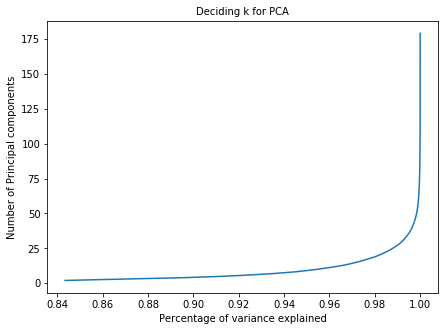

In [502]:
lr = LogisticRegression().fit(scale(X),y)
model = SelectFromModel(lr, prefit=True)
newdata = model.transform(X)

find_num_of_PCs(newdata)

Explained variance:  0.999937201096583
Logistic regression
AUC:0.8666666666666667
Confusion matrix:
[[27  3]
 [ 4 20]]
Accuracy: 0.8703703703703703
Sensitivity:0.8333333333333334
Specificity:0.9


Decision Tree:
AUC:0.7541666666666668
Confusion matrix:
[[24  6]
 [ 7 17]]
Accuracy: 0.7592592592592593
Sensitivity:0.7083333333333334
Specificity:0.8

 
Random forrest:
AUC:0.6791666666666667
Confusion matrix:
[[27  3]
 [13 11]]
Accuracy: 0.7037037037037037
Sensitivity:0.4583333333333333
Specificity:0.9

 
LGR
Avg loss: 0.16666666666666669

DT
Avg loss: 0.3611111111111111

RFC
Avg loss: 0.2888888888888889

